<a href="https://colab.research.google.com/github/LeandroTheodoro/Banco_de_dados_SHM/blob/main/Reprodu%C3%A7%C3%A3o_Metodologia_Atashipour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/OtavioCarvalho1/Time_Series.git

Cloning into 'Time_Series'...
remote: Enumerating objects: 1280, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1280 (delta 13), reused 0 (delta 0), pack-reused 1244
Receiving objects: 100% (1280/1280), 170.49 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1212/1212), done.


In [2]:
!git clone https://github.com/LeandroTheodoro/Banco_de_dados_SHM.git

Cloning into 'Banco_de_dados_SHM'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (405/405), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 405 (delta 11), reused 399 (delta 5), pack-reused 0
Receiving objects: 100% (405/405), 11.05 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12,8]

plt.rcParams.update({'font.size':16})

In [ ]:
sinal = pd.read_csv(filepath_or_buffer = '/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn1/PL0402_Dn11_10_100KHz__5ciclos_B3_A3.csv',
                    names = ['Tempo [s]', 'Amplitude PZT Atuador', 'Amplitude PZT Sensor'])

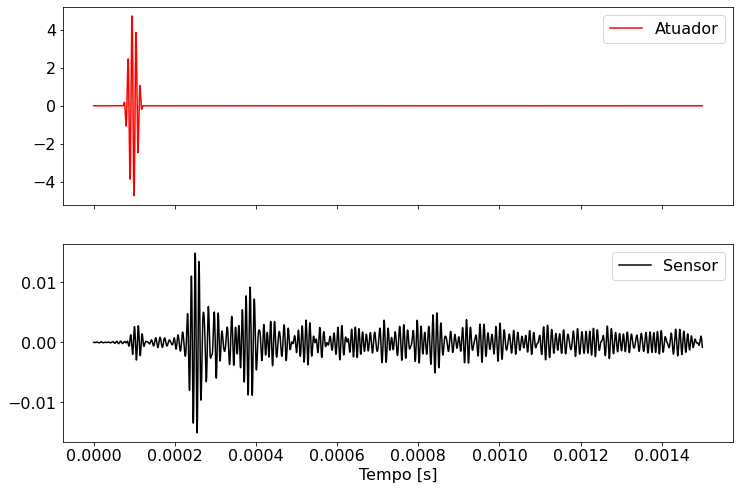

In [ ]:
fig, ax = plt.subplots(2,1,sharex = True)

ax[0].plot(sinal['Tempo [s]'], sinal['Amplitude PZT Atuador'], color = 'red', label = 'Atuador')
ax[0].legend()

ax[1].plot(sinal['Tempo [s]'], sinal['Amplitude PZT Sensor'], color = 'black', label = 'Sensor')
ax[1].set_xlabel('Tempo [s]')
ax[1].legend()

plt.show()

# **Pré-processamento**

## Windowing

Considerar apenas 400 $\mu$s do sinal

In [ ]:
# Determinar o índice que corresponde ao tempo de 400 microssegundos

sinal.index[sinal['Tempo [s]'] == 0.0004].values

array([4000])

In [ ]:
sinal.index[sinal['Tempo [s]'] == 0.0004].values[0]

4000

In [ ]:
sinalWindow = sinal.iloc[0:4001]

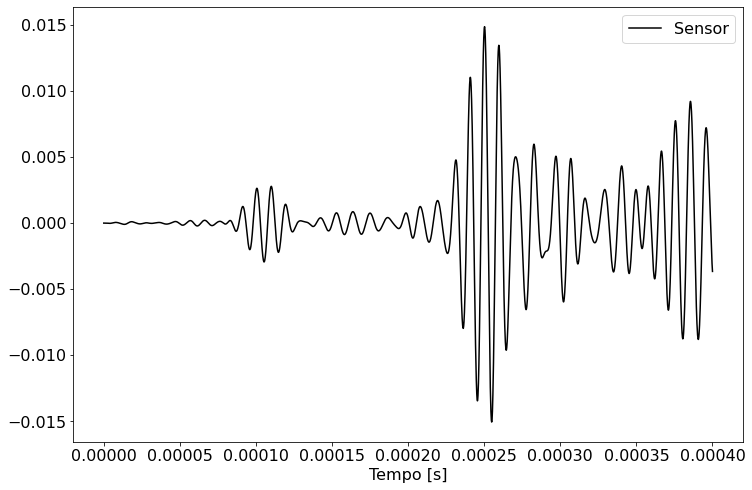

In [ ]:
fig2, ax2 = plt.subplots()

ax2.plot(sinalWindow['Tempo [s]'], sinalWindow['Amplitude PZT Sensor'], color = 'black', label = 'Sensor')
ax2.set_xlabel('Tempo [s]')
ax2.legend()

plt.show()

### DC Offset

In [ ]:
media = sinalWindow['Amplitude PZT Sensor'].mean()

In [ ]:
sinalWindow.loc[:,'Amplitude PZT Sensor'] = sinalWindow['Amplitude PZT Sensor'].apply(lambda x: x - media)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
sinalWindow['Amplitude PZT Sensor'].mean()

-8.617252958020255e-20

## Averaging

In [ ]:

def averaging(signal, ordem):
    '''
    Função para aplicar o processo de averaging indicado no artigo
    -----
    Input
    -----
    signal: np.array
        sinal que passará pelo processo
    ordem: int
        ordem da operação de média
    ------
    Output
    ------
    averageSignal: np.array
        sinal processado
    '''

    indiceAmostraInicial = int(ordem/2)

    indiceAmostraFinal = int(signal.shape[0] - ordem/2 - 1)

    averageSignal = np.empty(shape = int(signal.shape[0] - ordem))

    for k in range(indiceAmostraInicial,indiceAmostraFinal):

        averageSignal[k - indiceAmostraInicial] = signal[k - int(ordem/2) : k + int(ordem/2 + 1)].mean()

    return averageSignal

In [ ]:
signalAverage = averaging(signal = sinalWindow['Amplitude PZT Sensor'].values, ordem = 10)

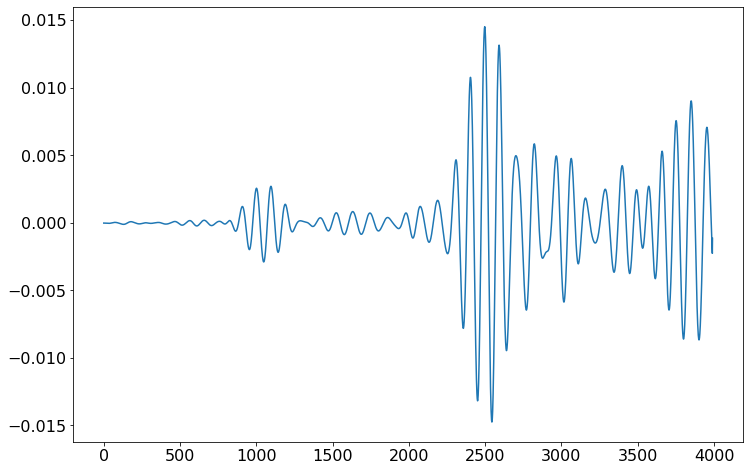

In [ ]:
plt.plot(signalAverage)

plt.show()

## Normalização

In [ ]:
peakAmplitude = np.abs(signalAverage).max()

In [ ]:
signalNormalized = signalAverage/peakAmplitude

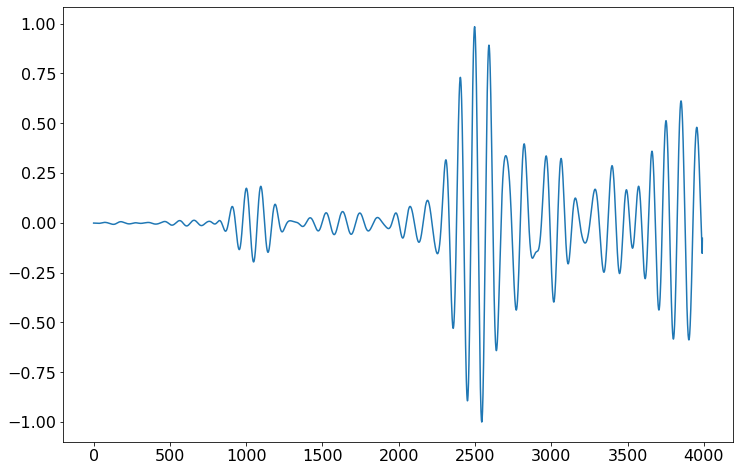

In [ ]:
plt.plot(signalNormalized)

plt.show()

In [ ]:
# Compute the Fast Fourier Transform (FFT)

dt = 10**(-7)
n = len(signalNormalized)
fhat = np.fft.fft(signalNormalized,n)                                    # Compute the FFT
PSD = fhat*np.conj(fhat)/n                                               # Power Spectrum (power per frequency)
freq = (1/(dt*n))*np.arange(n)                                           # Create x-axis of frequecies
L = np.arange(start=1,stop=np.floor(n),dtype='int')                      # Only plot the first half of freqs

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


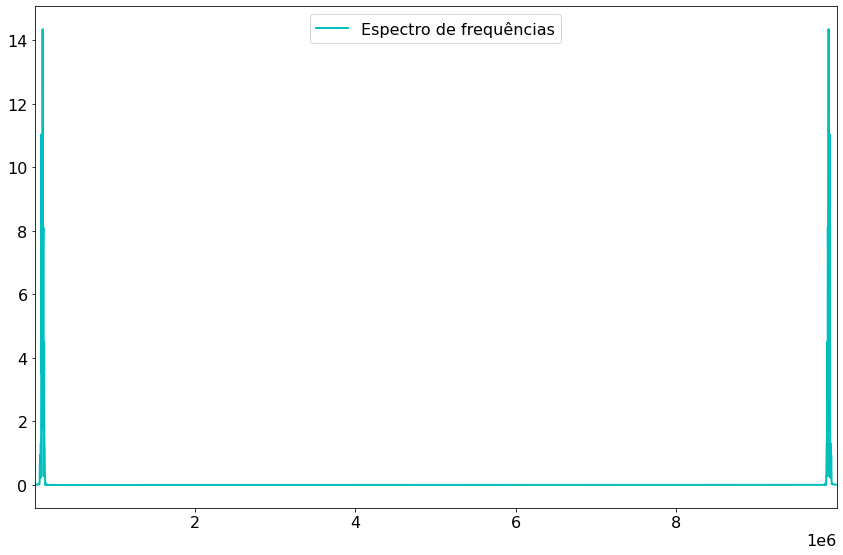

In [ ]:
plt.plot(freq[L],PSD[L],color='c',LineWidth=2,label='Espectro de frequências')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()
plt.tight_layout()
plt.show()

# **Processamento**

## Transformada wavelet contínua

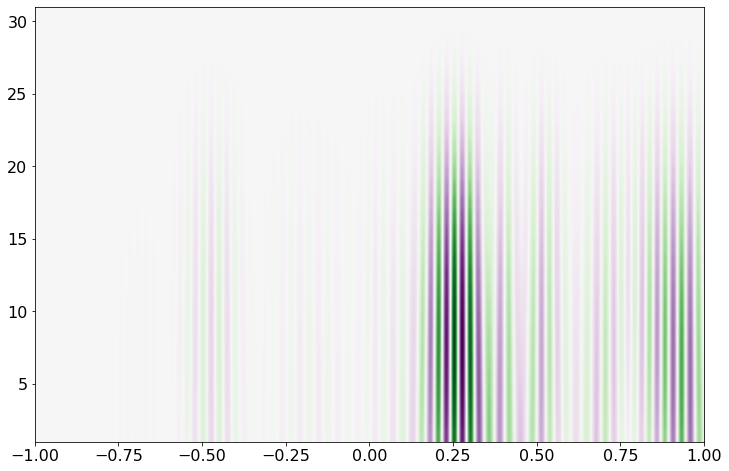

In [ ]:
import pywt

scales = np.arange(1, 31)
cwtcoeff, freqs = pywt.cwt(signalNormalized, scales, 'mexh')
plt.imshow(cwtcoeff, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwtcoeff).max(), vmin=-abs(cwtcoeff).max())
plt.show()

In [ ]:
SAP = (1/scales[-1])*(np.power(np.abs(cwtcoeff),2).sum(axis = 0))

SAP = (1/SAP.max())*SAP

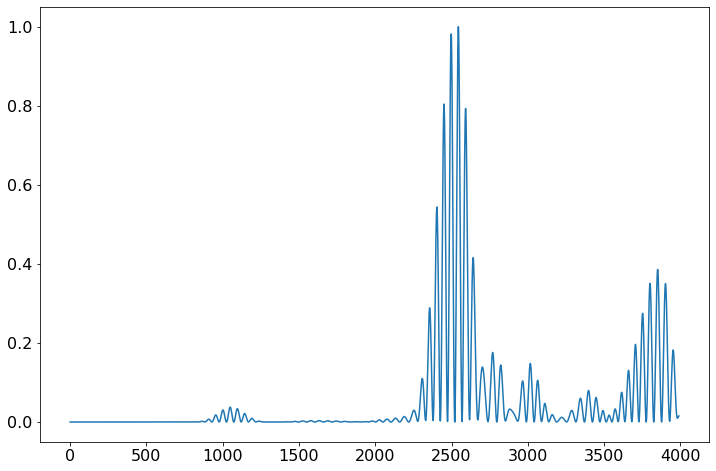

In [ ]:
plt.plot(SAP)

plt.show()

O ToF é calculado dessa forma abaixo? Não entendi essa parte.

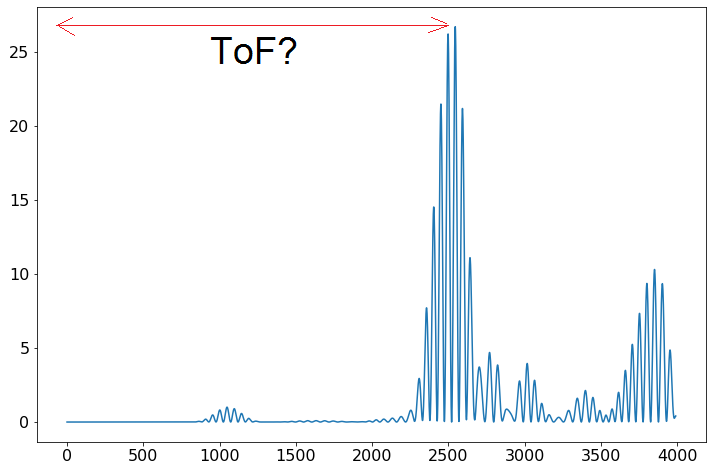

In [ ]:
from scipy.interpolate import interp1d

def gerarEnvelope(signal):
    '''
    Função para gerar o envelope do sinal SAP
    -----
    Input
    -----
    signal: np.array
        sinal de entrada 
    ------
    Output
    ------
    envelope: np.array
        envelope superior da curva
    '''

    envelope = np.empty(signal.shape[0])

    peak_x = [0,]
    peak_y = [signal[0],]

    for k in range(1, signal.shape[0] - 1):

        if (np.sign(signal[k]-signal[k-1]) == 1) and (np.sign(signal[k]-signal[k+1]) == 1):

            peak_x.append(k)

            peak_y.append(signal[k])

    peak_x.append(signal.shape[0])

    peak_y.append(signal[-1])
    
    u_p = interp1d(peak_x, peak_y, kind = 'cubic', bounds_error = False, fill_value = 0.0)

    for j in range(0, signal.shape[0]):

        envelope[j] = u_p(j)

    return envelope

In [ ]:
envelopeSAP = gerarEnvelope(signal = SAP)

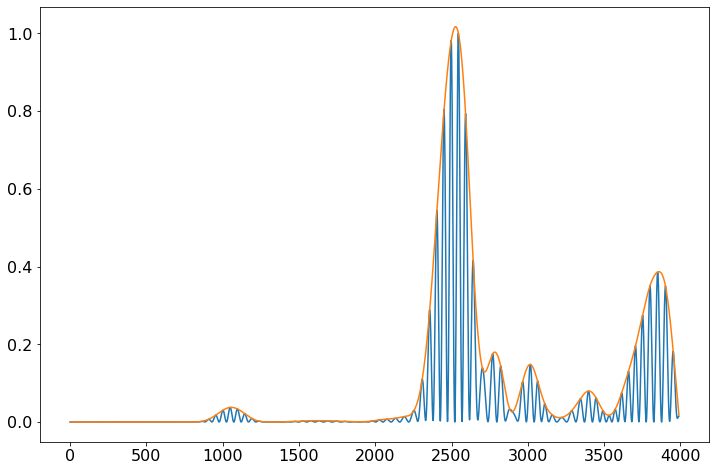

In [ ]:
plt.plot(SAP)

plt.plot(envelopeSAP)

plt.show()

In [ ]:
def amostrarCurva(signal, points):
    '''
    Função para amostrar os pontos de uma curva
    -----
    Input
    -----
    signal: np.array
        pontos da curva que deseja-se amostrar
    points: int
        quantidade de pontos da amostragem
    '''

    N = signal.shape[0]

    k = 0

    pointsSample = []

    while k < N:

        pointsSample.append((k, signal[k]))

        k += int(np.floor(N/points))

    n = len(pointsSample)

    pointsSample = np.array(pointsSample).reshape((n,2))

    return pointsSample

In [ ]:
samplePoints = amostrarCurva(signal = envelopeSAP, points = 80)

In [ ]:
samplePoints.shape

(82, 2)

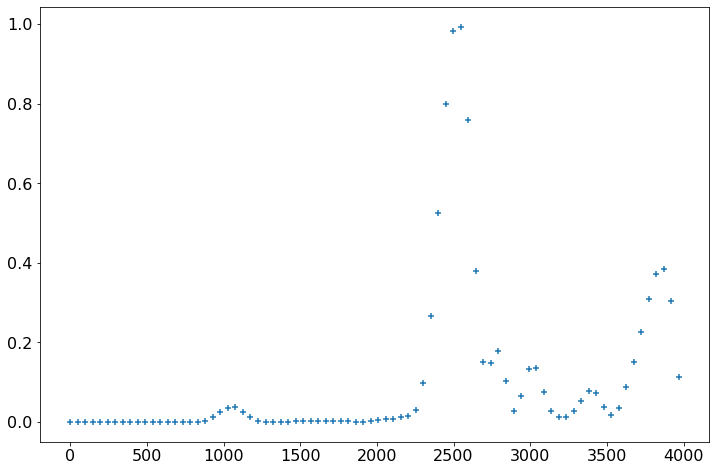

In [ ]:
plt.scatter(samplePoints[:,0], samplePoints[:,1], marker = '+')

plt.show()

In [ ]:
# Ainda precisa gerar as labels

def gerarDataset(signals, window, Points, labels):
    '''
    -----
    Input
    -----
    signals: list
        lista com os paths dos arquivos
    window: float
        tempo considerado para a janela de dados em segundos
    Points: int
        quantidade de pontos a serem considerados na amostragem da curva SAP
    labels: list
        labels das amostras
    ------
    Output
    ------
    df: pandas DataFrame
        dataset
    '''

    samples = []

    for path in signals:

        sinal = pd.read_csv(filepath_or_buffer = path, names = ['Tempo [s]', 'Amplitude PZT Atuador', 'Amplitude PZT Sensor'])

        idx = int(sinal.index[sinal['Tempo [s]'] == window].values[0] + 1)

        sinalWindow = sinal.iloc[0:idx]

        # DC offset

        media = sinalWindow['Amplitude PZT Sensor'].mean()

        sinalWindow.loc[:,'Amplitude PZT Sensor'] = sinalWindow['Amplitude PZT Sensor'].apply(lambda x: x - media)

        # Averaging

        signalAverage = averaging(signal = sinalWindow['Amplitude PZT Sensor'].values, ordem = 10)

        # Normalização

        peakAmplitude = np.abs(signalAverage).max()

        signalNormalized = signalAverage/peakAmplitude

        # Wavelet

        scales = np.arange(1, 31)

        cwtcoeff, freqs = pywt.cwt(signalNormalized, scales, 'mexh')

        SAP = (1/scales[-1])*(np.power(np.abs(cwtcoeff),2).sum(axis = 0))

        SAP = (1/SAP.max())*SAP

        envelopeSAP = gerarEnvelope(signal = SAP)

        # Amostrar a curva SAP

        samplePoints = list(amostrarCurva(signal = envelopeSAP, points = Points)[:,1])

        # Adicionar as labels

        for k in range(2):

            samplePoints.append(labels[k])

        # Armazenar as amostras

        samples.append(samplePoints)

    # Gerar um Dataframe

    df = pd.DataFrame(samples)

    return df

In [ ]:
from glob import glob

In [ ]:
pathSemDano = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Ref/*.csv')

pathDanoNivel_1 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn1/*.csv')

pathDanoNivel_2 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn2/*.csv')

pathDanoNivel_3 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn3/*.csv')

pathDanoNivel_4 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn4/*.csv')

pathDanoNivel_5 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn5/*.csv')

pathDanoNivel_6 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn6/*.csv')

pathDanoNivel_7 = glob('/content/Time_Series/Dataset-LambWave-Wagner/PL0402_Dn7/*.csv')

In [ ]:
datasetSemDano = gerarDataset(signals = pathSemDano, window = 0.00025, Points = 82, labels = [0,0])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetSemDano

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,1.279474e-06,1.763624e-05,0.000047,0.000618,0.000344,0.000025,0.000338,0.000281,0.000038,0.000237,0.000777,0.000024,0.000036,0.000407,0.000268,0.000032,0.000528,0.004865,0.012892,0.000355,0.000480,0.000452,0.000122,0.000012,0.000222,0.000080,0.000125,-0.007690,0.141661,0.361774,0.440031,0.298457,0.053966,0.014077,0.026885,0.120488,0.031443,0.009528,0.002226,0.125993,...,0.126630,0.161760,0.063844,0.167620,0.017204,0.121363,0.212759,0.102491,0.043535,0.124164,0.130612,0.116757,0.010940,0.002975,0.002662,0.080620,0.101808,0.093999,0.166113,0.249459,0.047917,0.013118,0.000761,0.001699,0.020030,0.008160,0.027859,0.021896,0.042356,0.061094,0.096031,0.048833,0.049077,0.042823,0.090098,0.115175,0.061079,0.042368,0,0
1,5.404851e-07,1.575916e-05,0.000393,0.000120,0.000067,0.000330,0.000183,0.000200,0.000575,0.000763,0.000099,0.000092,0.000036,0.000289,0.000016,0.000104,0.000150,0.003766,0.018268,0.010396,0.000454,0.000127,0.000179,0.000015,0.000193,0.000391,0.000072,0.000137,0.066528,0.142964,0.056516,0.245600,0.012910,0.044772,0.060388,0.102231,0.042276,0.004822,0.004767,0.108963,...,0.446219,0.013186,0.151871,0.231166,0.154116,0.119204,0.181604,0.094201,0.030462,0.073945,0.172996,0.157539,0.050970,0.013950,0.020008,0.079023,0.064625,0.020093,0.017281,0.248938,0.159890,0.036006,0.028622,0.008033,0.009365,0.025455,0.039770,0.059170,0.054415,0.013901,0.007971,0.012565,0.013196,0.007960,0.029870,0.062391,0.016265,0.001832,0,0
2,1.470070e-07,5.647912e-06,0.000025,0.000036,0.000013,0.000007,0.000039,0.000032,0.000015,0.000045,0.000073,0.000048,0.000038,0.000022,0.000082,-0.000462,-0.000940,0.004473,0.049227,0.157732,0.209508,0.128769,0.028423,0.001084,-0.000370,-0.000049,-0.000103,-0.000499,0.001200,0.009885,0.026690,0.037427,0.039925,0.036983,0.025734,0.013219,0.007694,0.005820,0.003702,0.005428,...,0.569982,0.644818,0.639543,0.703672,0.945865,0.941631,0.563736,0.326753,0.207692,0.043354,0.016437,0.177769,0.395755,0.404659,0.246554,0.136213,0.094971,0.067689,0.051466,0.040614,0.044926,0.062185,0.059349,0.044896,0.055459,0.104469,0.139732,0.128709,0.075637,0.027494,0.015558,0.012338,0.010934,0.013834,0.007307,0.004741,0.013581,0.015590,0,0
3,1.094954e-07,4.480730e-06,0.000015,0.000030,0.000025,0.000027,0.000061,0.000036,0.000013,0.000050,0.000081,0.000035,0.000023,0.000013,0.000077,-0.000527,-0.000951,0.004416,0.047824,0.152655,0.203007,0.123923,0.028278,-0.006340,-0.011198,-0.003603,0.000365,-0.000360,0.001202,0.009839,0.026632,0.037909,0.040681,0.036834,0.025373,0.012960,0.007622,0.005766,0.003809,0.005610,...,0.568648,0.642196,0.638725,0.702458,0.949879,0.942889,0.562382,0.328287,0.208660,0.045947,0.016331,0.176368,0.398254,0.402584,0.244983,0.137589,0.096017,0.068306,0.053314,0.040826,0.044518,0.060744,0.057815,0.044190,0.054909,0.104411,0.139747,0.128289,0.075371,0.026693,0.015409,0.011947,0.010832,0.013724,0.007106,0.004762,0.013703,0.015625,0,0
4,2.971369e-08,-2.020300e-07,0.000009,0.000058,0.000033,0.000014,0.000030,0.000029,0.000013,0.000047,0.000073,0.000044,0.000027,0.000028,-0.000010,0.000067,-0.000838,0.005032,0.050219,0.159301,0.212220,0.129661,0.028747,0.001033,-0.000740,-0.000380,0.000051,0.000001,0.001207,0.009715,0.026718,0.037892,0.040765,0.037602,0.025866,0.013587,0.007658,0.005918,0.003691,0.005349,...,0.576900,0.652781,0.644273,0.707302,0.948487,0.940330,0.560345,0.322617,0.205177,0.043434,0.017134,0.182019,0.397628,0.406360,0.246193,0.135312,0.094662,0.066255,0.051453,0.041140,0.045856,0.062380,0.059203,0.045345,0.055473,0.104909,0.141235,0.129334,0.075980,0.027692,0.015542,0.011640,0.010476,0.014040,0.007515,0.004863,0.013795,0.015269,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
datasetDano_1 = gerarDataset(signals = pathDanoNivel_1, window = 0.00025, Points = 82, labels = [1,1])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_2 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,2])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_3 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,3])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_4 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,4])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_5 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,5])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_6 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,6])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
datasetDano_7 = gerarDataset(signals = pathDanoNivel_2, window = 0.00025, Points = 82, labels = [1,7])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [ ]:
dataset = pd.concat(objs = [datasetSemDano, datasetDano_1, datasetDano_2, datasetDano_3, datasetDano_4, datasetDano_5, datasetDano_6, datasetDano_7])

In [ ]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,1.279474e-06,1.763624e-05,0.000047,0.000618,0.000344,0.000025,0.000338,0.000281,0.000038,0.000237,0.000777,0.000024,0.000036,0.000407,0.000268,0.000032,0.000528,0.004865,1.289167e-02,0.000355,0.000480,0.000452,0.000122,0.000012,0.000222,0.000080,0.000125,-0.007690,0.141661,0.361774,0.440031,0.298457,0.053966,0.014077,0.026885,0.120488,0.031443,0.009528,0.002226,0.125993,...,0.126630,0.161760,0.063844,0.167620,0.017204,0.121363,0.212759,0.102491,0.043535,0.124164,0.130612,0.116757,0.010940,0.002975,0.002662,0.080620,0.101808,0.093999,0.166113,0.249459,0.047917,0.013118,0.000761,0.001699,0.020030,0.008160,0.027859,0.021896,0.042356,0.061094,0.096031,0.048833,0.049077,0.042823,0.090098,0.115175,0.061079,0.042368,0,0
1,5.404851e-07,1.575916e-05,0.000393,0.000120,0.000067,0.000330,0.000183,0.000200,0.000575,0.000763,0.000099,0.000092,0.000036,0.000289,0.000016,0.000104,0.000150,0.003766,1.826822e-02,0.010396,0.000454,0.000127,0.000179,0.000015,0.000193,0.000391,0.000072,0.000137,0.066528,0.142964,0.056516,0.245600,0.012910,0.044772,0.060388,0.102231,0.042276,0.004822,0.004767,0.108963,...,0.446219,0.013186,0.151871,0.231166,0.154116,0.119204,0.181604,0.094201,0.030462,0.073945,0.172996,0.157539,0.050970,0.013950,0.020008,0.079023,0.064625,0.020093,0.017281,0.248938,0.159890,0.036006,0.028622,0.008033,0.009365,0.025455,0.039770,0.059170,0.054415,0.013901,0.007971,0.012565,0.013196,0.007960,0.029870,0.062391,0.016265,0.001832,0,0
2,1.470070e-07,5.647912e-06,0.000025,0.000036,0.000013,0.000007,0.000039,0.000032,0.000015,0.000045,0.000073,0.000048,0.000038,0.000022,0.000082,-0.000462,-0.000940,0.004473,4.922652e-02,0.157732,0.209508,0.128769,0.028423,0.001084,-0.000370,-0.000049,-0.000103,-0.000499,0.001200,0.009885,0.026690,0.037427,0.039925,0.036983,0.025734,0.013219,0.007694,0.005820,0.003702,0.005428,...,0.569982,0.644818,0.639543,0.703672,0.945865,0.941631,0.563736,0.326753,0.207692,0.043354,0.016437,0.177769,0.395755,0.404659,0.246554,0.136213,0.094971,0.067689,0.051466,0.040614,0.044926,0.062185,0.059349,0.044896,0.055459,0.104469,0.139732,0.128709,0.075637,0.027494,0.015558,0.012338,0.010934,0.013834,0.007307,0.004741,0.013581,0.015590,0,0
3,1.094954e-07,4.480730e-06,0.000015,0.000030,0.000025,0.000027,0.000061,0.000036,0.000013,0.000050,0.000081,0.000035,0.000023,0.000013,0.000077,-0.000527,-0.000951,0.004416,4.782366e-02,0.152655,0.203007,0.123923,0.028278,-0.006340,-0.011198,-0.003603,0.000365,-0.000360,0.001202,0.009839,0.026632,0.037909,0.040681,0.036834,0.025373,0.012960,0.007622,0.005766,0.003809,0.005610,...,0.568648,0.642196,0.638725,0.702458,0.949879,0.942889,0.562382,0.328287,0.208660,0.045947,0.016331,0.176368,0.398254,0.402584,0.244983,0.137589,0.096017,0.068306,0.053314,0.040826,0.044518,0.060744,0.057815,0.044190,0.054909,0.104411,0.139747,0.128289,0.075371,0.026693,0.015409,0.011947,0.010832,0.013724,0.007106,0.004762,0.013703,0.015625,0,0
4,2.971369e-08,-2.020300e-07,0.000009,0.000058,0.000033,0.000014,0.000030,0.000029,0.000013,0.000047,0.000073,0.000044,0.000027,0.000028,-0.000010,0.000067,-0.000838,0.005032,5.021893e-02,0.159301,0.212220,0.129661,0.028747,0.001033,-0.000740,-0.000380,0.000051,0.000001,0.001207,0.009715,0.026718,0.037892,0.040765,0.037602,0.025866,0.013587,0.007658,0.005918,0.003691,0.005349,...,0.576900,0.652781,0.644273,0.707302,0.948487,0.940330,0.560345,0.322617,0.205177,0.043434,0.017134,0.182019,0.397628,0.406360,0.246193,0.135312,0.094662,0.066255,0.051453,0.041140,0.045856,0.062380,0.059203,0.045345,0.055473,0.104909,0.141235,0.129334,0.075980,0.027692,0.015542,0.011640,0.010476,0.014040,0.007515,0.004863,0.013795,0.015269,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
dataset.to_excel('dataset_SHM.xlsx')